In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import json
from os import listdir, mkdir
from os.path import isdir
import os
from math import ceil, isnan
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content/drive/Shareddrives/soone/summary_data"

In [ ]:
def get_all_user_id():
    return [f[:-4] for f in listdir("/content/drive/Shareddrives/soone/user_data")]
get_all_user_id()[:10]

['1004',
 '1003',
 '1002',
 '1001',
 '30016',
 '1054',
 '1055',
 '1056',
 '1053',
 '1052']

In [ ]:
def get_sleep_data(id):
    df = pd.read_csv(f"/content/drive/Shareddrives/soone/user_data/{id}.csv", encoding="cp949")
    sleep_record = []
    sleep_stack = []
    for idx, row in df.iterrows():
        t = datetime.strptime(row["Time"][1:], "%Y-%m-%d %H:%M:%S")
        if len(sleep_stack) == 0 and ("취침" in row["Act"]) and \
        (t.hour <= 5 or t.hour >= 20): # 수면 시작
            sleep_stack.append(row["Time"])
        elif len(sleep_stack) == 1 and ("기상" in row["Act"]):  # 수면 종료
            
            end = datetime.strptime(row["Time"][1:], "%Y-%m-%d %H:%M:%S")
            start = datetime.strptime(sleep_stack[0][1:],"%Y-%m-%d %H:%M:%S")
            td = end - start # 수면 시간 길이 계산

            td_hr = td.seconds / 3600
            sleep_record.append({"start":start, "end":end, 
                                "length":td_hr})
            sleep_stack.pop()
    #print(sleep_record)
    # export 할 dataframe 생성
    sleep_df = pd.DataFrame(sleep_record)
    sleep_hr_df = pd.DataFrame(index=pd.date_range(start="2021-08-01", end="2021-08-31", freq='D'), data={"amount":[0 for i in range(31)], "start":[None for i in range(31)], "end":[None for i in range(31)]})
    for idx, row in sleep_df.iterrows():
        target_day = datetime.strptime(str(row["start"]).split()[0], "%Y-%m-%d")
        sleep_hr_df["amount"][target_day] += row["length"]
        if sleep_hr_df["start"][target_day] == None:
            sleep_hr_df["start"][target_day] = row["start"].hour + row["start"].minute / 60
        if sleep_hr_df["end"][target_day] == None:
            sleep_hr_df["end"][target_day] = row["end"].hour + row["end"].minute /60
    # 수면 score 계산
    score = 100 - abs(sleep_hr_df["amount"].mean() - 7.5)/7.5 *100 - sleep_hr_df["amount"].std() * 10
    return sleep_hr_df, score

In [ ]:
sleep_hr_df, score = get_sleep_data("1001")
sleep_hr_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28:

,amount,start,end
2021-08-01,0.000000,None,None
2021-08-02,0.000000,None,None
2021-08-03,0.000000,None,None
2021-08-04,1.086667,20.1833,21.2667
2021-08-05,0.000000,None,None


In [ ]:
def generate_daily_sleep_record():
    users = get_all_user_id()
    for u in tqdm(users):
        sleep_hr_df, score = get_sleep_data(u)
        # make dir for user data
        if not isdir(os.path.join(BASE_DIR,u)):
            mkdir(os.path.join(BASE_DIR,u))
        # make dir for user sleep data
        if not isdir(os.path.join(BASE_DIR,u, "sleep")):
            mkdir(os.path.join(BASE_DIR,u, "sleep"))
        sleep_dir = os.path.join(BASE_DIR,u, "sleep")
        daily_json_list = [[] for _ in range(ceil(31/7))]
        i = 0
        for _, row in sleep_hr_df.iterrows():
            daily_record = {}
            daily_record["up"], daily_record["down"], daily_record["length"] = row["end"], row["start"], row["amount"]
            daily_json_list[i//7].append(daily_record)
            i += 1
        
        f = open(os.path.join(sleep_dir, "daily.json"), "w")
        json.dump(daily_json_list,f, indent=4)
        f.close()


In [ ]:
generate_daily_sleep_record()

  0%|          | 0/170 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/

In [ ]:
def generate_summary():
    users = get_all_user_id()
    score_list = []
    avg_down_list = []
    avg_up_list = []
    avg_length_list = []
    
    for u in tqdm(users):
        sleep_hr_df, score = get_sleep_data(u)
        # make dir for user data
        if not isdir(os.path.join(BASE_DIR,u)):
            mkdir(os.path.join(BASE_DIR,u))
        # make dir for user sleep data
        if not isdir(os.path.join(BASE_DIR,u, "sleep")):
            mkdir(os.path.join(BASE_DIR,u, "sleep"))
        sleep_dir = os.path.join(BASE_DIR,u, "sleep")

        up_list = []
        down_list = []
        for h in sleep_hr_df["end"]:
            if h == None:
                up_list.append(None)
            else:
                if h >= 20:
                    up_list.append(24-h)
                else:
                    up_list.append(h)
        for h in sleep_hr_df["start"]:
            if h == None:
                down_list.append(None)
            else:
                if h >= 20:
                    down_list.append(24-h)
                else:
                    down_list.append(h)
        
        up_list = np.array(up_list)
        up_list = up_list[up_list!=None]
        down_list = np.array(down_list)
        down_list = down_list[down_list!=None]
        if len(up_list) == 0:
            avg_up = None
            avg_down = None

        else:
            avg_up = up_list[up_list!=None].mean()
            avg_down = down_list[up_list!=None].mean()
        if avg_up and avg_up < 0:
            avg_up += 24
        if avg_down and avg_down < 0:
             avg_down += 24
        avg_length = sleep_hr_df["amount"].mean()
      
        if avg_up and isnan(avg_up): avg_up = None
        if avg_down and isnan(avg_down): avg_down = None
        all_none_check = True
        score_list.append(score)
        avg_up_list.append(avg_up)
        avg_down_list.append(avg_down)
        avg_length_list.append(avg_length)

        score += 36.03032676920116
        score = max(0, score)
        summary = {"avg_up":avg_up, "avg_down":avg_down,"avg_length":avg_length,
                   "score":score}
        
        f = open(os.path.join(sleep_dir, "monthly.json"), "w")
        json.dump(summary,f, indent=4)
        f.close()
    
    all_user_average = {"avg_up":np.array(avg_up).mean(),
                        "avg_down": np.array(avg_down).mean(),
                        "avg_length":sum(avg_length_list)/len(avg_length_list),
                        "score":sum(score_list)/len(score_list) - min(score_list)
                        }
    if not isdir(os.path.join(BASE_DIR,"all_user")):
            mkdir(os.path.join(BASE_DIR,"all_user"))
    if not isdir(os.path.join(BASE_DIR,"all_user", "sleep")):
            mkdir(os.path.join(BASE_DIR,"all_user", "sleep"))
    

    f = open(os.path.join(BASE_DIR, "all_user","sleep","all_user_average.json"), "w")
    json.dump(all_user_average,f, indent=4)
    f.close()

def translate_time(t):
    if t >= 20:
        return 24 - t
    else:
        return t


def generate_outliers():
    users = get_all_user_id()
    for u in tqdm(users):
        sleep_hr_df, score = get_sleep_data(u)
        
        sleep_dir = os.path.join(BASE_DIR,u, "sleep")
        daily_json_list = [[] for _ in range(ceil(31/7))]
        i = 0
        up_list, down_list, length_list = [], [], []

        for _, row in sleep_hr_df.iterrows():
            if row["start"]:
                down_list.append(translate_time(row["start"]))
            if row["end"]:
                up_list.append(translate_time(row["end"]))
            if row["amount"]:
                length_list.append(row["amount"])
        up_list = np.array(up_list)
        down_list = np.array(down_list)
        length_list = np.array(length_list)

        up_mean, up_std = up_list.mean(), up_list.std()
        down_mean, down_std = down_list.mean(), down_list.std()
        length_mean, length_std = length_list.mean(), length_list.std()

        i = 1
        outlier = {"up":[], "down":[],"length":[]}
        for _, row in sleep_hr_df.iterrows():
            if row["start"] and abs(translate_time(row["start"])-down_mean) > down_std:
                outlier["down"].append(i)
                # print(f"time : {row['start']}, std : {down_std}, mean : {down_mean}")
            if row["end"] and abs(translate_time(row["end"])-up_mean) > up_std:
                outlier["up"].append(i)
            if row["amount"] and abs(row["amount"]-length_mean) > length_std:
                outlier["length"].append(i)

            i += 1
        
        f = open(os.path.join(sleep_dir, "outlier.json"), "w")
        json.dump(outlier,f, indent=4)
        f.close()

In [ ]:
generate_summary()

  0%|          | 0/170 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/

In [ ]:
generate_outliers()

  0%|          | 0/170 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/

  0%|          | 0/170 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/

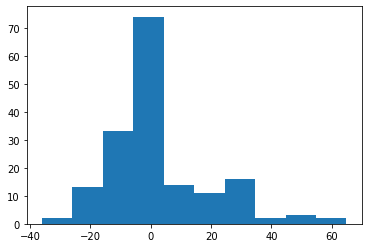

min score : -36.03032676920116, max score : 64.86527554398431


In [ ]:
def show_score_dist():
    score_list = []
    users = get_all_user_id()
    for u in tqdm(users):
        sleep_hr_df, score = get_sleep_data(u)
        score_list.append(score)
    plt.hist(score_list)
    plt.show()
    print(f"min score : {min(score_list)}, max score : {max(score_list)}")


show_score_dist()



In [ ]:
sleep_hr_df.describe(exclude=[None])

,start,end
count,6.000000,6.000000
unique,6.000000,6.000000
top,4.983333,15.533333
freq,1.000000,1.000000
